In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
df = pd.read_csv('user_profile.csv')

In [3]:
df.shape

(800, 3)

In [4]:
df.head()

,name,ethnicity,gender
0,Woody,Caucasian (White),Male
1,Del,Other,Male
2,Steven,Mixed,Male
3,Keli Lu,Asian,Male
4,Dee,Mixed,Male


In [5]:
# check null values
df[df.isnull().any(axis=1)]

,name,ethnicity,gender
599,NaN,Other,Female


In [6]:
# remove null value
df = df.dropna().reset_index(drop=True)

In [7]:
# verify null values has been deleted
df[df.isnull().any(axis=1)]

,name,ethnicity,gender


In [8]:
df_chart = df['gender'].value_counts()
print(df_chart)

Male      400
Female    399
Name: gender, dtype: int64


In [9]:
df_chart = df['ethnicity'].value_counts()
print(df_chart)

Hispanic / Latino        230
No Answer                170
Caucasian (White)        137
Asian                    124
Mixed                     42
Black                     26
Chinese                   23
Indian                    19
Other                     15
Malay                      6
Pacific Islander           3
Prefer not to say          3
Arab (Middle Eastern)      1
Name: ethnicity, dtype: int64


In [10]:
conditions = ['No Answer', 'Mixed', 'Other', 'Prefer not to say', 'Pacific Islander', 'Arab (Middle Eastern)', 'Black']
df = df.drop(df[df['ethnicity'].isin(conditions)].index)

In [11]:
df.shape

(539, 3)

In [12]:
df_chart = df['ethnicity'].value_counts()
print(df_chart)

Hispanic / Latino    230
Caucasian (White)    137
Asian                124
Chinese               23
Indian                19
Malay                  6
Name: ethnicity, dtype: int64


In [13]:
transform_values = ['Chinese', 'Indian', 'Malay']
df.loc[df['ethnicity'].isin(transform_values), 'ethnicity'] = 'Asian'

In [14]:
df_chart = df['ethnicity'].value_counts()
print(df_chart)

Hispanic / Latino    230
Asian                172
Caucasian (White)    137
Name: ethnicity, dtype: int64


In [15]:
df_chart = df['gender'].value_counts()
print(df_chart)

Female    313
Male      226
Name: gender, dtype: int64


<AxesSubplot:title={'center':'Ethnicity'}>

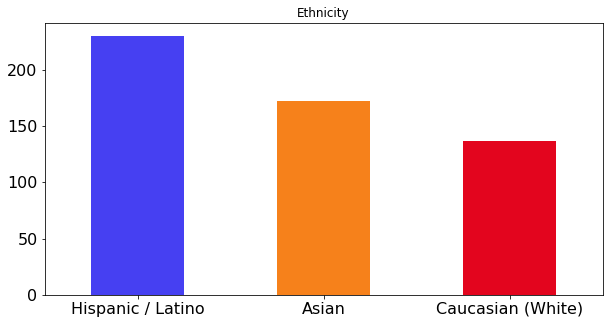

In [16]:
df_chart_ethnicity = df['ethnicity'].value_counts()
df_chart_ethnicity.plot(kind='bar', rot=0, color=['#4640F2', '#F6811B', '#e3051e'], figsize=(10,5), fontsize=16, title='Ethnicity')

<AxesSubplot:title={'center':'Gender'}>

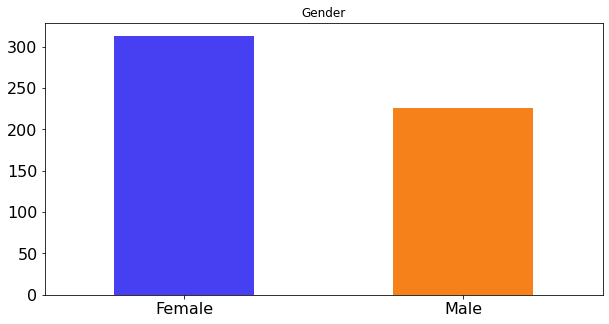

In [17]:
df_gender_chart = df['gender'].value_counts()
df_gender_chart.plot(kind='bar', rot=0, color=['#4640F2', '#F6811B'], figsize=(10,5), fontsize=16, title='Gender')

**Split dataset**

In [100]:
# Gender
X_gender = df['name']
y_gender = df['gender']
y_gender = y_gender.apply(lambda x: 1 if x == 'Male' else 0)

In [101]:
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_gender, y_gender, test_size=0.15, random_state=42, stratify=y_gender)

In [48]:
X_train_g, X_valid_g, y_train_g, y_valid_g = train_test_split(X_train_g, y_train_g, test_size=0.15, random_state=42, stratify=y_train_g)

In [102]:
print(y_train_g.shape)
print(y_valid_g.shape)
print(y_test_g.shape)

(458,)
(69,)
(81,)


**Transformer Approach**

In [2]:
albert_name = 'albert-base-v2'
tokenizer = AlbertTokenizer.from_pretrained(albert_name,
    add_special_tokens=True,
    do_lower_case=False,
    max_length=80,
    pad_to_max_length=True)

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [23]:
def albert_encoder(review):
    encoded = tokenizer.encode_plus(review, add_special_tokens=True,
        max_length=80,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_token_type_ids=True)
    return encoded['input_ids'], encoded['token_type_ids'], encoded['attention_mask']

In [43]:
# X train gender
X_train_g = [albert_encoder(X_train_g.iloc[i]) for i in range(X_train_g.shape[0])]
X_train_g = np.array(X_train_g)

y_train_g = y_train_g.to_list()
y_train_g = np.array(y_train_g)
y_train_g = to_categorical(y_train_g, num_classes=2)

C:\Users\kok19\anaconda3\envs\scraping\lib\site-packages\transformers\tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [45]:
# X valid gender
X_valid_g = [albert_encoder(X_valid_g.iloc[i]) for i in range(X_valid_g.shape[0])]
X_valid_g = np.array(X_valid_g)

y_valid_g = y_valid_g.to_list()
y_valid_g = np.array(y_valid_g)
y_valid_g = to_categorical(y_valid_g, num_classes=2)

In [46]:
tr_name, tr_segments, tr_masks = np.split(X_train_g, 3, axis=1)
val_name, val_segments, val_masks = np.split(X_valid_g, 3, axis=1)
print(tr_name.shape)

(389, 1, 80)


In [48]:
tr_name = tr_name.squeeze()
tr_segments = tr_segments.squeeze()
tr_masks = tr_masks.squeeze()

val_name = val_name.squeeze()
val_segments = val_segments.squeeze()
val_masks = val_masks.squeeze()

print(tr_name.shape)

(389, 80)


In [49]:
def example_to_features(input_ids,attention_masks,token_type_ids,y):
    return {"input_ids": input_ids,"attention_mask": attention_masks,"token_type_ids": token_type_ids},y

In [51]:
train_ds = tf.data.Dataset.from_tensor_slices((tr_name, tr_masks, tr_segments, y_train_g)).map(example_to_features).shuffle(100).batch(8)
valid_ds = tf.data.Dataset.from_tensor_slices((val_name,val_masks, val_segments, y_valid_g)).map(example_to_features).shuffle(100).batch(8)

In [52]:
albert_model = TFAlbertForSequenceClassification.from_pretrained(albert_name)

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFAlbertForSequenceClassification.

Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
optimizer = Adam(learning_rate=2e-5)
loss = BinaryCrossentropy(from_logits=True)
albert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [55]:
albert_model.summary()

Model: "tf_albert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
albert (TFAlbertMainLayer)   multiple                  11683584  
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 11,685,122
Trainable params: 11,685,122
Non-trainable params: 0
_________________________________________________________________


In [56]:
print("Fine-tuning ALBERT")
albert_history = albert_model.fit(train_ds, epochs=3, validation_data=valid_ds)

Fine-tuning ALBERT
Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the

49/49 [==============================] - 1502s 31s/step - loss: 0.6958 - accuracy: 0.5733 - val_loss: 0.6799 - val_accuracy: 0.5797
Epoch 2/3
49/49 [==============================] - 1475s 30s/step - loss: 0.6820 - accuracy: 0.5835 - val_loss: 0.6728 - val_accuracy: 0.5797
Epoch 3/3
49/49 [==============================] - 1528s 31s/step - loss: 0.6745 - accuracy: 0.5835 - val_loss: 0.6668 - val_accuracy: 0.5942
